In [1]:
from casadi import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
N = 50 # number of control intervals
L = 2.7

opti = Opti() # Optimization problem

# ---- decision variables ---------
X = opti.variable(5,N+1) # state trajectory x, y, theta, v, phi
x = X[0,:]
y = X[1,:]
theta = X[2,:]
v = X[3,:]
phi = X[4,:]

U = opti.variable(2,N)   # control trajectory (accleration, phi_dot)
a = U[0,:]
phi_dot = U[1,:]

T = opti.variable()      # final time

# ---- dynamic constraints --------
f = lambda x,u: vertcat(x[3]*np.cos(x[2]), x[3]*np.sin(x[2]), x[3]*np.tan(x[4])/L, u[0], u[1]) # dx/dt = f(x,u) = [dx, dy, d_theta, v, phi]

dt = T/N # length of a control interval
for k in range(N): # loop over control intervals
   # Runge-Kutta 4 integration
   k1 = f(X[:,k],         U[:,k])
   k2 = f(X[:,k]+dt/2*k1, U[:,k])
   k3 = f(X[:,k]+dt/2*k2, U[:,k])
   k4 = f(X[:,k]+dt*k3,   U[:,k])
   x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 
   opti.subject_to(X[:,k+1]==x_next) # close the gaps

# ---- path constraints -----------
# State limits
opti.subject_to(opti.bounded(-7.75, v, 77.75))   # track speed limit
opti.subject_to(opti.bounded(-0.58206731, phi, 0.58206731))   # steering angle limit
# Control limits
opti.subject_to(opti.bounded(-12.0, a, 4.0))   # steering angle limit
opti.subject_to(opti.bounded(-0.28206731, phi_dot, 0.28206731))   # steering angle limit

# ---- boundary conditions --------
opti.subject_to(x[0]==0)   # start at position 0 ...
opti.subject_to(y[0]==0)   # start at position 0 ...
opti.subject_to(theta[0]==0)   # start at position 0 ...

opti.subject_to(v[0]==0) # ... from stand-still 
opti.subject_to(v[-1]==0) # ... to stand-still 
opti.subject_to(phi[0]==0)
opti.subject_to(phi[-1]==0)

# Final position constaints
opti.subject_to(x[-1]**2 <= 0.001)
opti.subject_to((y[-1] - 4*L)**2 <= 0.001)
opti.subject_to(theta[-1]==0)

# ---- misc. constraints  ----------
opti.subject_to(T>=0) # Time must be positive

# ---- initial values for solver ---
# opti.set_initial(v, 0.0)
# opti.set_initial(phi, 0.0)
opti.set_initial(T, 1)

# ---- objective          ---------
opti.minimize(T + 0.01*sum([(a[k])**2 for k in range(N)]) + 0.01*sum([(phi_dot[k]*100)**2 for k in range(N)])) # race in minimal time

# ---- solve NLP              ------
opti.solver("ipopt") # set numerical backend
sol = opti.solve()   # actual solve


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1558
Number of nonzeros in inequality constraint Jacobian.:      205
Number of nonzeros in Lagrangian Hessian.............:     1003

Total number of variables............................:      356
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

  83r3.7432971e+002 6.54e-001 1.24e+003  -5.5 1.00e+001   1.9 7.06e-006 2.42e-002f  1
  84r3.7566572e+002 6.54e-001 1.33e+003  -5.5 4.43e-001   2.3 7.33e-002 6.82e-001f  1
  85r3.7528408e+002 6.54e-001 6.95e+002  -5.5 1.89e-001   2.8 2.52e-001 5.36e-001f  1
  86r3.7503773e+002 6.54e-001 7.05e+002  -5.5 1.07e+000   2.3 1.80e-002 1.29e-001f  1
  87r3.7503567e+002 6.54e-001 6.98e+002  -5.5 2.82e-001   2.7 1.23e-002 9.43e-003f  1
  88r3.7497964e+002 6.54e-001 6.95e+002  -5.5 1.70e+000   2.2 1.49e-003 5.53e-003f  1
  89r3.7497639e+002 6.54e-001 6.90e+002  -5.5 3.28e-001   2.7 4.08e-002 3.07e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90r3.7491901e+002 6.54e-001 6.88e+002  -5.5 2.36e+000   2.2 6.15e-003 3.03e-003f  1
  91r3.7486150e+002 6.54e-001 6.66e+002  -5.5 3.81e-001   2.6 3.71e-002 3.19e-002f  1
  92r3.7486035e+002 6.54e-001 6.67e+002  -5.5 3.33e+000   2.1 1.05e-002 3.87e-005f  1
  93r3.7477288e+002 6.54e-001 6.45e+002  -5.5 4.44e-001   2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190r3.5193503e+002 6.51e-001 2.12e+002  -5.5 8.83e+000   1.4 1.08e-002 1.74e-002f  1
 191r3.5322399e+002 6.50e-001 2.05e+002  -5.5 1.31e+000   1.9 7.00e-001 2.51e-002f  1
 192r3.5332071e+002 6.50e-001 2.70e+002  -5.5 4.57e-001   2.3 1.00e+000 1.27e-002f  1
 193r3.5275291e+002 6.50e-001 2.74e+002  -5.5 1.49e+000   1.8 2.84e-001 3.43e-002f  1
 194r3.5203106e+002 6.49e-001 2.32e+002  -5.5 5.19e-001   2.2 1.00e+000 3.28e-001f  1
 195r3.5191387e+002 6.49e-001 2.27e+002  -5.5 1.74e+000   1.8 2.66e-001 6.79e-003f  1
 196r3.5239025e+002 6.44e-001 1.08e+002  -5.5 5.46e-001   2.2 1.00e+000 5.11e-001f  1
 197r3.5403205e+002 6.40e-001 9.03e+001  -5.5 1.86e+000   1.7 2.65e-001 1.30e-001f  1
 198r3.5403207e+002 6.40e-001 9.28e+001  -5.5 6.28e-001   2.1 1.00e+000 2.08e-006f  1
 199r3.5428709e+002 6.39e-001 1.09e+002  -5.5 2.03e+000   1.7 1.97e-001 8.17e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

<IPython.core.display.Javascript object>


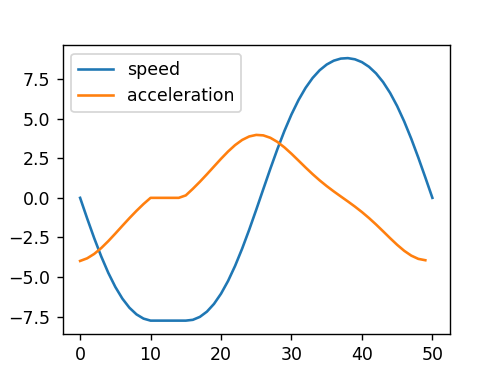

<IPython.core.display.Javascript object>


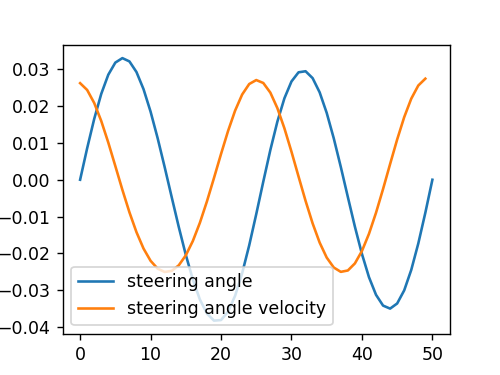

<IPython.core.display.Javascript object>


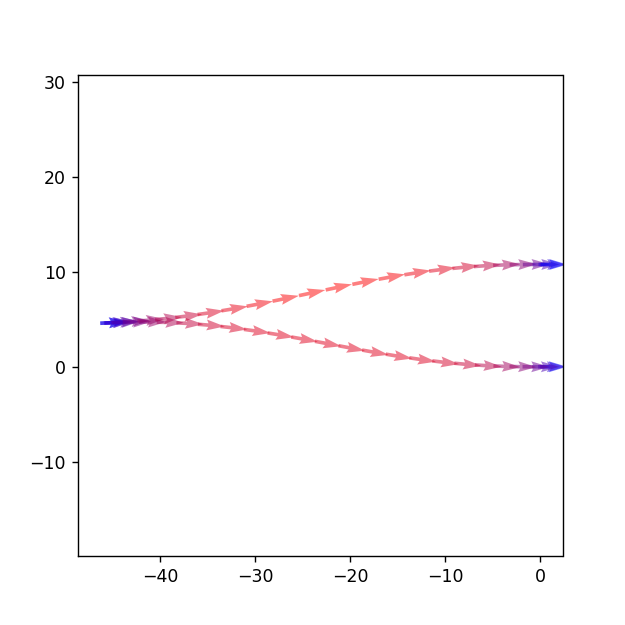

In [4]:
%matplotlib notebook

# Plotting
plt.figure(figsize=(4,3))
plt.plot(sol.value(v),label="speed")
plt.plot(sol.value(a),label="acceleration")
plt.legend(loc="best")
plt.figure(figsize=(4,3))
plt.plot(sol.value(phi),label="steering angle")
plt.plot(sol.value(phi_dot),label="steering angle velocity")
plt.legend(loc="best")

plt.figure(figsize=(5,5))
plt.axis("equal")
xs = sol.value(x)
ys = sol.value(y)
vs = sol.value(v)
thetas = sol.value(theta)

# Creating colors array based on velocity
cols = np.abs(vs)
cols = np.interp(cols, (cols.min(), cols.max()), (0, 1)).astype(np.float)

for i in range(N+1):
    plt.quiver(xs[i], ys[i], np.cos(thetas[i]), np.sin(thetas[i]), color=(cols[i],0,1-cols[i]), alpha=0.5)

plt.show()